### Model sieci rekurencyjnej z wykorzystaniem spektrogramów Mel'a i augmentacją danych audio

### Import bibliotek

In [1]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import random
import json

# Klasyfikacja ML
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# Deep Learning (TensorFlow)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam


# Wizualizacja
import seaborn as sns


### Wczytanie zbioru nEMO

In [2]:
dataset = load_dataset("amu-cai/nEMO", split="train")

### Zastosowanie augmentacji plików audio

In [3]:
"""Dodaje biały szum do audio."""
def add_noise(audio, noise_factor=0.005):
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_factor * noise
    return augmented_audio
    
"""Rozciąga czas (przyspiesza lub spowalnia) audio."""
def time_stretch(audio, rate=None):
    if rate is None:
        rate = np.random.uniform(0.85, 1.15)
    return librosa.effects.time_stretch(y=audio, rate=rate)

"""Zmienia wysokość tonu audio."""
def pitch_shift(audio, sr, n_steps=None):
    if n_steps is None:
        n_steps = np.random.uniform(-2, 2)
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)
    
"""Zmienia głośność audio."""
def change_volume(audio, volume_factor=None):
    if volume_factor is None:
        volume_factor = np.random.uniform(0.8, 1.2)
    return audio * volume_factor

"""Aplikuje losowe augmentacje z określonym prawdopodobieństwem."""
def apply_augmentation(audio, sr, augment_prob=0.5):
    augmented = np.copy(audio)
    
    if random.random() < augment_prob:
        augmented = add_noise(augmented, noise_factor=random.uniform(0.001, 0.01))
    
    if random.random() < augment_prob:
        augmented = time_stretch(augmented)
    
    if random.random() < augment_prob:
        augmented = pitch_shift(augmented, sr)
    
    if random.random() < augment_prob:
        augmented = change_volume(augmented)
    
    return augmented

### Przygotowanie spektrogramów Mel'a 

In [5]:
def audio_to_mel_spectrogram(audio_array, sr=24000):
    n_fft = 1024
    hop_length = 256
    audio_array = audio_array / (np.max(np.abs(audio_array)) + 1e-10)
    pre_emphasis = np.append(audio_array[0], audio_array[1:] - 0.97 * audio_array[:-1])
    
    mel_spec = librosa.feature.melspectrogram(
        y=pre_emphasis,
        sr=sr,
        n_mels=80,
        n_fft=n_fft,
        hop_length=hop_length,
        power=2.0,
        fmax=8000
    )
    
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max, top_db=80)
    mel_spec_norm = (mel_spec_db - np.min(mel_spec_db)) / (np.max(mel_spec_db) - np.min(mel_spec_db) + 1e-10)
    return mel_spec_norm

###  Przygotowanie danych

In [6]:
audio_files = [sample['audio']['array'] for sample in dataset]
sample_rates = [sample['audio']['sampling_rate'] for sample in dataset]
labels = [sample['emotion'] for sample in dataset]

# Konwertowanie etykiet emocji na liczby
emotion_labels = {emotion: idx for idx, emotion in enumerate(sorted(set(labels)))}
numeric_labels = [emotion_labels[label] for label in labels]

print("Mapowanie etykiet emocji:")
for emotion, idx in emotion_labels.items():
    print(f"  {emotion}: {idx}")

mel_specs = []
mel_aug_labels = []

# Docelowy rozmiar spektrogramu
mel_target_size = (80, 200)

# Dla każdej próbki audio
for audio, sr, label in zip(audio_files, sample_rates, numeric_labels):
    # Przycinanie lub paddowanie audio do stałej długości (5 sekund)
    max_len = 5 * sr
    if len(audio) > max_len:
        start = np.random.randint(0, len(audio) - max_len)
        audio = audio[start:start + max_len]
    else:
        padding = np.zeros(max_len - len(audio))
        audio = np.concatenate([audio, padding])
    
    # Dodanie oryginalnej próbki
    mel_spec = audio_to_mel_spectrogram(audio, sr=sr)
    
    # Zmiana rozmiaru spektrogramu
    mel_spec = tf.convert_to_tensor(mel_spec, dtype=tf.float32)
    mel_spec = tf.expand_dims(mel_spec, axis=-1)
    mel_spec = tf.image.resize(mel_spec, mel_target_size)
    mel_spec = tf.squeeze(mel_spec).numpy()
    
    mel_specs.append(mel_spec)
    mel_aug_labels.append(label)
    
    # Dodanie augmentowanych próbek
    for _ in range(2):
        augmented_audio = apply_augmentation(audio, sr)
        aug_mel_spec = audio_to_mel_spectrogram(augmented_audio, sr=sr)
        
        aug_mel_spec = tf.convert_to_tensor(aug_mel_spec, dtype=tf.float32)
        aug_mel_spec = tf.expand_dims(aug_mel_spec, axis=-1)
        aug_mel_spec = tf.image.resize(aug_mel_spec, mel_target_size)
        aug_mel_spec = tf.squeeze(aug_mel_spec).numpy()
        
        mel_specs.append(aug_mel_spec)
        mel_aug_labels.append(label)

# Konwersja na numpy arrays dla CNN
X_mel = np.array(mel_specs).reshape(-1, mel_target_size[0], mel_target_size[1], 1)
y_mel = np.array(mel_aug_labels).astype('int32')


# Wyświetlanie informacji o kształcie danych
print(f"Kształt danych X: {X_mel.shape}")
print(f"Kształt danych y: {y_mel.shape}")

Mapowanie etykiet emocji:
  anger: 0
  fear: 1
  happiness: 2
  neutral: 3
  sadness: 4
  surprised: 5
Kształt danych X: (13443, 80, 200, 1)
Kształt danych y: (13443,)


### Podział na zbiory: treningowy, walidacyjny i testowy. Najpierw dzielimy indeksy, aby zapewnić spójność podziału między różnymi cechami

In [7]:
indices = np.arange(len(y_mel))
indices_train, indices_temp, y_train, y_temp = train_test_split(
    indices, y_mel, test_size=0.3, random_state=42, stratify=y_mel
)
indices_val, indices_test, y_val, y_test = train_test_split(
    indices_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


X_mel_train, X_mel_val, X_mel_test = X_mel[indices_train], X_mel[indices_val], X_mel[indices_test]

print(f"Rozmiar zbioru treningowego: {len(y_train)} próbek")
print(f"Rozmiar zbioru walidacyjnego: {len(y_val)} próbek")
print(f"Rozmiar zbioru testowego: {len(y_test)} próbek")

# Wyświetl rozkład klas w zbiorze treningowym
class_counts = np.bincount(y_train)
print("\nRozkład klas w zbiorze treningowym:")
for label, count in enumerate(class_counts):
    emotion = [k for k, v in emotion_labels.items() if v == label][0]
    print(f"  {emotion}: {count} próbek")

# Obliczenie wag klas dla zrównoważenia
class_weights = {}
total_samples = len(y_train)
n_classes = len(emotion_labels)
for label, count in enumerate(class_counts):
    class_weights[label] = total_samples / (n_classes * count)

print("\nWagi klas:")
for label, weight in class_weights.items():
    emotion = [k for k, v in emotion_labels.items() if v == label][0]
    print(f"  {emotion}: {weight:.4f}")

Rozmiar zbioru treningowego: 9410 próbek
Rozmiar zbioru walidacyjnego: 2016 próbek
Rozmiar zbioru testowego: 2017 próbek

Rozkład klas w zbiorze treningowym:
  anger: 1573 próbek
  fear: 1545 próbek
  happiness: 1573 próbek
  neutral: 1699 próbek
  sadness: 1615 próbek
  surprised: 1405 próbek

Wagi klas:
  anger: 0.9970
  fear: 1.0151
  happiness: 0.9970
  neutral: 0.9231
  sadness: 0.9711
  surprised: 1.1163


### Trenowanie modelu

In [8]:
def create_cnn_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D((2, 2)),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D((2, 2)),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPool2D((2, 2)),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.GlobalAveragePooling2D(),
        
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model
# Funkcja zmieniająca współczynnik uczenia w zależności od epoki
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    elif epoch < 10:
        return lr * 0.5
    elif epoch < 15:
        return lr * 0.25
    else:
        return lr * 0.1


print("\n===== TRENING MODELU CNN DLA SPEKTROGRAMÓW MEL'a =====")
cnn_model = create_cnn_model((80, 200, 1), len(emotion_labels))
cnn_model.summary()

cnn_callbacks = [
    tf.keras.callbacks.LearningRateScheduler(lr_scheduler),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_cnn_emotion_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
]

cnn_history = cnn_model.fit(
    X_mel_train, y_train,
    validation_data=(X_mel_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=cnn_callbacks,
    class_weight=class_weights,
    verbose=1
)

# Ładowanie najlepszego modelu
try:
    best_model = tf.keras.models.load_model('best_cnn_emotion_model.keras')
    print("Wczytano najlepszy model z pliku best_cnn_emotion_model.keras")
except:
    best_model = cnn_model
    print("Używamy modelu z końca treningu")

# Ocena modelu na zbiorze testowym
test_loss, test_acc = cnn_model.evaluate(X_mel_test, y_test, verbose=1)
print(f"\nDokładność na zbiorze testowym: {test_acc:.4f}")

# Predykcja na zbiorze testowym
y_pred = best_model.predict(X_mel_test)
y_pred_classes = np.argmax(y_pred, axis=1)


===== TRENING MODELU CNN DLA SPEKTROGRAMÓW MEL'a =====


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ (None, 80, 200, 1)          │               4 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 80, 200, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 40, 100, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 40, 100, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 40, 100, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 20, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,962 (429.54 KB)

 Trainable params: 109,960 (429.53 KB)

 Non-trainable params: 2 (8.00 B)

Epoch 1/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1596 - loss: 1.7967
Epoch 1: val_accuracy improved from -inf to 0.20585, saving model to best_cnn_emotion_model.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 413s 1s/step - accuracy: 0.1597 - loss: 1.7966 - val_accuracy: 0.2059 - val_loss: 1.7873 - learning_rate: 0.0010
Epoch 2/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1945 - loss: 1.7832
Epoch 2: val_accuracy improved from 0.20585 to 0.25546, saving model to best_cnn_emotion_model.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 389s 1s/step - accuracy: 0.1945 - loss: 1.7832 - val_accuracy: 0.2555 - val_loss: 1.7359 - learning_rate: 0.0010
Epoch 3/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2585 - loss: 1.7014
Epoch 3: val_accuracy improved from 0.25546 to 0.34673, saving model to best_cnn_emotion_model.keras
295/295 ━━━━━━━━━━━━━━━━━━━━ 390s 1s/step - accuracy: 0.2586 - loss: 1.7013 - val_accuracy: 0.3467 - val_loss: 1.5890 - learning_rate: 0.0010
Epoch 4/20
295/295 

### Metryki modelu


Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.44      0.73      0.55       337
           1       0.67      0.41      0.51       332
           2       0.36      0.25      0.29       337
           3       0.41      0.52      0.45       364
           4       0.52      0.76      0.62       346
           5       0.45      0.10      0.16       301

    accuracy                           0.47      2017
   macro avg       0.47      0.46      0.43      2017
weighted avg       0.47      0.47      0.44      2017


Macierz pomyłek:
[[245   6  23  55   7   1]
 [ 54 136   9  44  89   0]
 [143  28  83  59   7  17]
 [ 26   3  37 188  95  15]
 [  3  22   6  49 263   3]
 [ 80   8  75  69  40  29]]

Macro F1-score: 0.4308


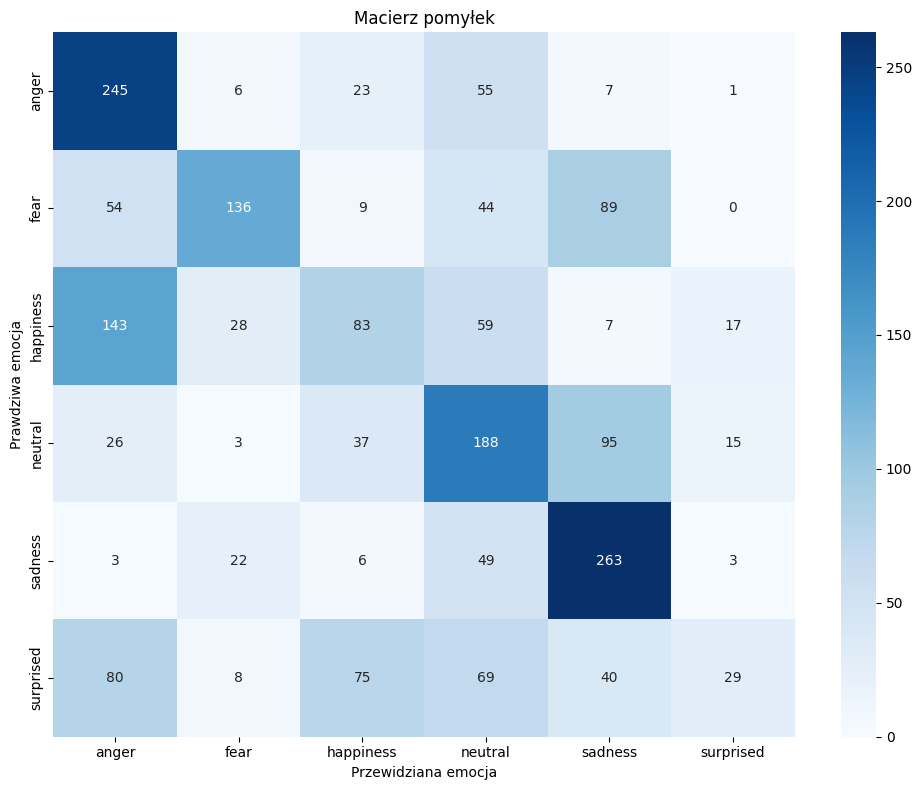

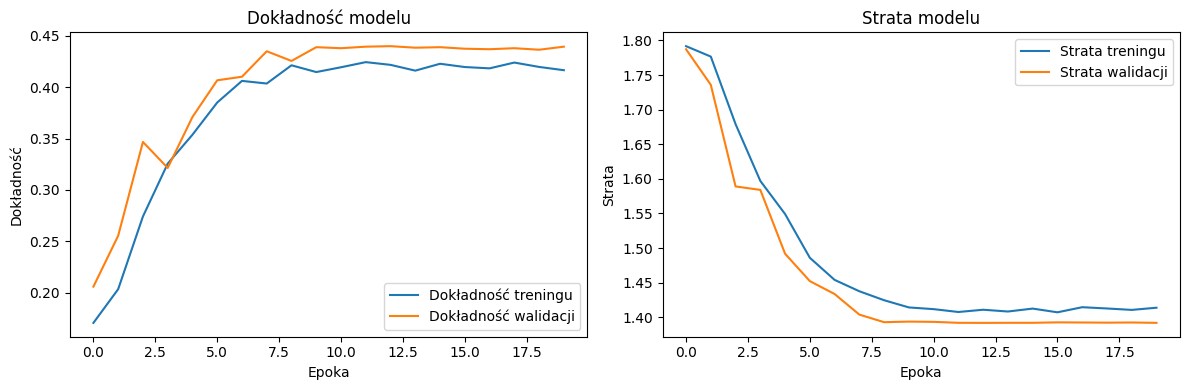

Zapisano mapowanie etykiet do pliku emotion_labels.json


In [9]:
# Raport klasyfikacji
print("\nRaport klasyfikacji:")
print(classification_report(y_test, y_pred_classes))

# Macierz pomyłek
cm = confusion_matrix(y_test, y_pred_classes)
print("\nMacierz pomyłek:")
print(cm)

# Obliczanie F1-score
f1_macro = f1_score(y_test, y_pred_classes, average='macro')
print(f"\nMacro F1-score: {f1_macro:.4f}")

# Wykresy
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[k for k in emotion_labels.keys()],
            yticklabels=[k for k in emotion_labels.keys()])
plt.xlabel('Przewidziana emocja')
plt.ylabel('Prawdziwa emocja')
plt.title('Macierz pomyłek')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Dokładność treningu')
plt.plot(cnn_history.history['val_accuracy'], label='Dokładność walidacji')
plt.title('Dokładność modelu')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='Strata treningu')
plt.plot(cnn_history.history['val_loss'], label='Strata walidacji')
plt.title('Strata modelu')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Zapisanie mapowania etykiet
with open('emotion_labels.json', 'w') as f:
    json.dump(emotion_labels, f)
print(f"Zapisano mapowanie etykiet do pliku emotion_labels.json")

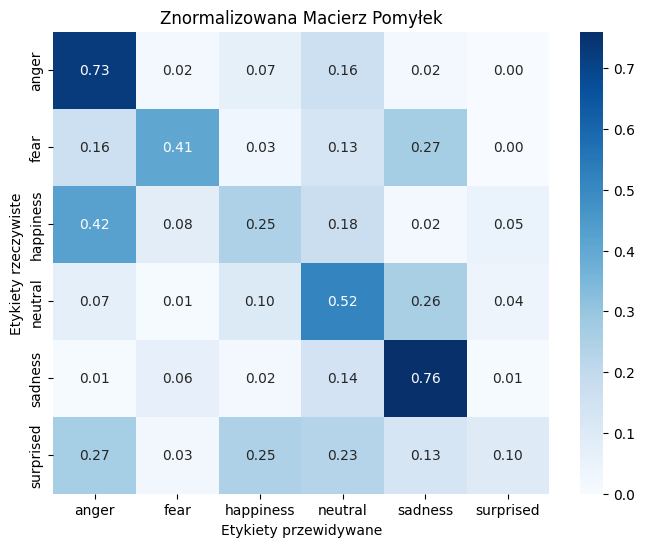

In [10]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Rysowanie macierzy pomyłek
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel('Etykiety przewidywane')
plt.ylabel('Etykiety rzeczywiste')
plt.title('Znormalizowana Macierz Pomyłek')
plt.savefig('normalized_confusion_matrix.png', format='png', dpi=300)
plt.show()